In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [4]:
df = pd.read_csv(r"/content/ETH-CAD.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-12-15,1774.078003,1776.305786,1725.049561,1729.443115,1729.443115,8238998179
1,2022-12-16,1729.588745,1743.423950,1596.422607,1604.779419,1604.779419,12771938777
2,2022-12-17,1604.514893,1633.331665,1600.862427,1632.101685,1632.101685,6974376257
3,2022-12-18,1632.072754,1640.432739,1616.608643,1621.749634,1621.749634,4585921549
4,2022-12-19,1621.808594,1628.836182,1584.431274,1593.005249,1593.005249,6744740114


In [5]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
361,2023-12-11,3182.836670,3227.958984,3158.321533,3195.044434,3195.044434,10009181726
362,2023-12-12,3195.090332,3198.997559,2930.936279,3020.684326,3020.684326,24427026200
363,2023-12-13,3020.429443,3041.812256,2949.301270,2991.695313,2991.695313,15476026418
364,2023-12-14,2992.459473,3085.551514,2924.115967,3054.204346,3054.204346,16991087603
365,2023-12-15,3104.641846,3106.802734,2983.234863,3003.600830,3003.600830,13576281088


In [6]:
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


Policy Gradient

# DQN-Learning

In [ ]:
df = pd.read_csv(r"/content/ETH-CAD.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-12-15,1774.078003,1776.305786,1725.049561,1729.443115,1729.443115,8238998179
1,2022-12-16,1729.588745,1743.423950,1596.422607,1604.779419,1604.779419,12771938777
2,2022-12-17,1604.514893,1633.331665,1600.862427,1632.101685,1632.101685,6974376257
3,2022-12-18,1632.072754,1640.432739,1616.608643,1621.749634,1621.749634,4585921549
4,2022-12-19,1621.808594,1628.836182,1584.431274,1593.005249,1593.005249,6744740114


In [ ]:
from collections import deque
import random


class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.99
        self.epsilon = 0.4
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.8

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )

    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost

    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)

            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))


            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )

            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)

                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]

                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]

                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest,
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size,
              window_size = window_size,
              trend = close,
              skip = skip,
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size,
              window_size = window_size,
              trend = close,
              skip = skip,
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

In [ ]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size,
              window_size = window_size,
              trend = close,
              skip = skip,
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
<ipython-input-11-a5f14f8d66b2>:26: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
<ipython-input-11-a5f14f8d66b2>:27: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(feed, self.action_size)


epoch: 10, total rewards: 4904.241940.3, cost: 2.659809, total money: 14904.241940
epoch: 20, total rewards: 6063.772948.3, cost: 0.049648, total money: 16063.772948
epoch: 30, total rewards: 6345.083739.3, cost: 0.104831, total money: 16345.083739
epoch: 40, total rewards: 5798.612671.3, cost: 0.027740, total money: 15798.612671
epoch: 50, total rewards: 4029.764036.3, cost: 0.047109, total money: 14029.764036
epoch: 60, total rewards: 4920.798584.3, cost: 0.008737, total money: 14920.798584
epoch: 70, total rewards: 4153.636839.3, cost: 0.045978, total money: 14153.636839
epoch: 80, total rewards: 2752.086303.3, cost: 0.031343, total money: 12752.086303
epoch: 90, total rewards: 3423.541994.3, cost: 0.024514, total money: 13423.541994
epoch: 100, total rewards: 3533.407712.3, cost: 0.022176, total money: 13533.407712
epoch: 110, total rewards: 3523.812010.3, cost: 0.044384, total money: 13523.812010
epoch: 120, total rewards: 2512.570799.3, cost: 0.055565, total money: 12512.570799
e

In [ ]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 1: buy 1 unit at price 1604.779419, total balance 8395.220581
day 2: buy 1 unit at price 1632.101685, total balance 6763.118896
day 4, sell 1 unit at price 1593.005249, investment -0.733694 %, total balance 8356.124145,
day 5, sell 1 unit at price 1656.212036, investment 1.477258 %, total balance 10012.336181,
day 10: buy 1 unit at price 1659.014648, total balance 8353.321533
day 11: buy 1 unit at price 1663.715820, total balance 6689.605713
day 12, sell 1 unit at price 1640.312866, investment -1.127283 %, total balance 8329.918579,
day 13: buy 1 unit at price 1618.496460, total balance 6711.422119
day 14, sell 1 unit at price 1628.673584, investment -2.106263 %, total balance 8340.095703,
day 15, sell 1 unit at price 1627.291748, investment 0.543423 %, total balance 9967.387451,
day 16: buy 1 unit at price 1623.958740, total balance 8343.428711
day 17: buy 1 unit at price 1625.373779, total balance 6718.054932
day 20, sell 1 unit at price 1694.551758, investment 4.346971 %, total 

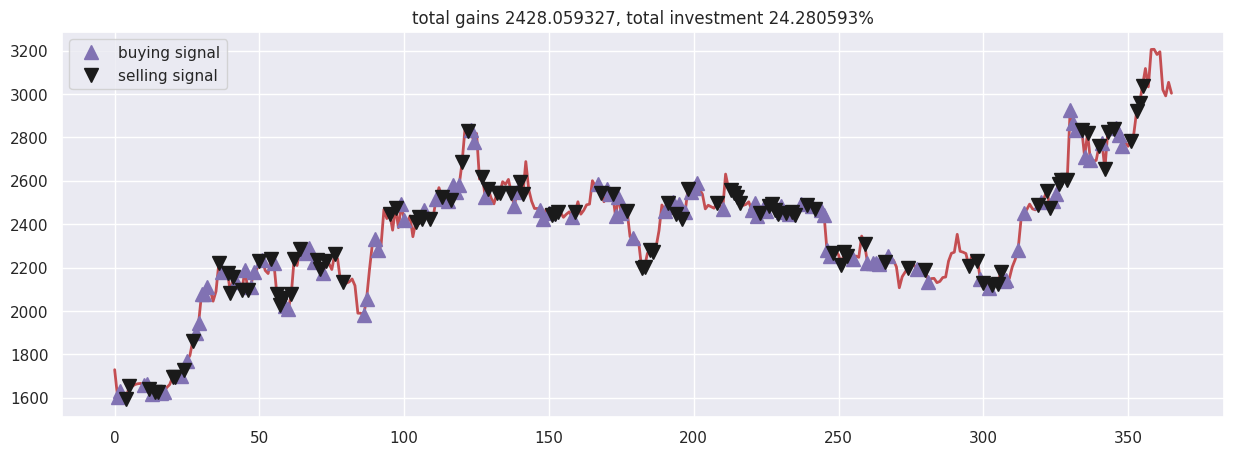

In [ ]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()